
# Random Acts of Pizza

###### By Dan Price, Gautam Karnataki and Neil Mukerje

** Table of Contents **

1. [Introduction](#Introduction)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Feature Selection and Extraction](#Feature-Selection-and-Extraction)
4. [Text Classification](#Text-Classification)
5. [Non-Text Classification](#Non-Text-Classification)<br>
6. [Building an Ensemble Classifier](#Building-an-Ensemble-Classifier)
7. [Kaggle Submission](#Kaggle-Submission)
8. [Conclusion](#Conclusion)

## Introduction

Reddit's Random Acts of Pizza subreddit (https://www.reddit.com/r/Random_Acts_Of_Pizza/) is where people can request free pizza from others on the Internet. The objective of this exercise is to predict which pizza requests will be successful based on the features of those requests. 

This dataset is available in Kaggle - https://www.kaggle.com/c/random-acts-of-pizza

In [21]:
import scipy
import string
import datetime
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import json
import random
import re
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.optimize import minimize
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import itertools
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = pd.read_json("data/train.json")
test_df = pd.read_json("data/test.json")

print ("Training Data shape : %s" % str(train_df.shape))
print ("Test Data shape : %s" % str(test_df.shape))

Training Data shape : (4040, 32)
Test Data shape : (1631, 17)


Our Training dataset has 4040 records and 32 features and our Test dataset has 1631 records and 17 features. The 17 features in the Test dataset are what we will need to work on to make a Kaggle submission eventually. We will get rid of the extra features in the Training data set later in this notebook.

We define some utlity functions next that we will use later in this notebook - 'expresses_locality' that detects if a text contains US locality information like state, city etc. and 'evaluate' that helps evaluates a model.

In [2]:
#The 2 class names for this exercise.
class_names = ['No-Pizza','Pizza']
#Utility method that we are goind to evaluate our models.
def evaluate(classes,y_true,y_pred,
                          normalize=True,
                          title='Confusion matrix'):
    print (classification_report(y_true, y_pred))
    
    cm=confusion_matrix(y_true,y_pred)
    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap=plt.cm.Blues
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    print ("Metrics.roc_auc_score : %f" % metrics.roc_auc_score(y_true, y_pred))

with open('states.json', encoding='utf-8') as f:
    states = json.load(f)
with open('countries.json', encoding='utf-8') as f:
    countries = json.load(f)

# check whether string contains state or country
def expresses_locality(string):
    for state in states.values():
        if state.lower() in string.lower():
            return True
    for country in countries.values():
        if country.lower() in string.lower():
            return True
    for state_abbrev in states.keys():
        abbrevs = []
        abbrevs.append(", " + state_abbrev + " ")
        abbrevs.append("," + state_abbrev + " ")
        for abbrev in abbrevs:
            if abbrev in string:
                return True
    return False

## Exploratory Data Analysis

In [3]:
train_df.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True      994
dtype: int64

We observe that around 1 in 4 requests are successful so our classes are skewed with 994 success records and 3046 failed records in our Training dataset. We will balance the classes later in this notebook by oversampling the success records.

Our classes are now balanced with 3046 records each. Let us view the histograms of the columns in our training dataset.

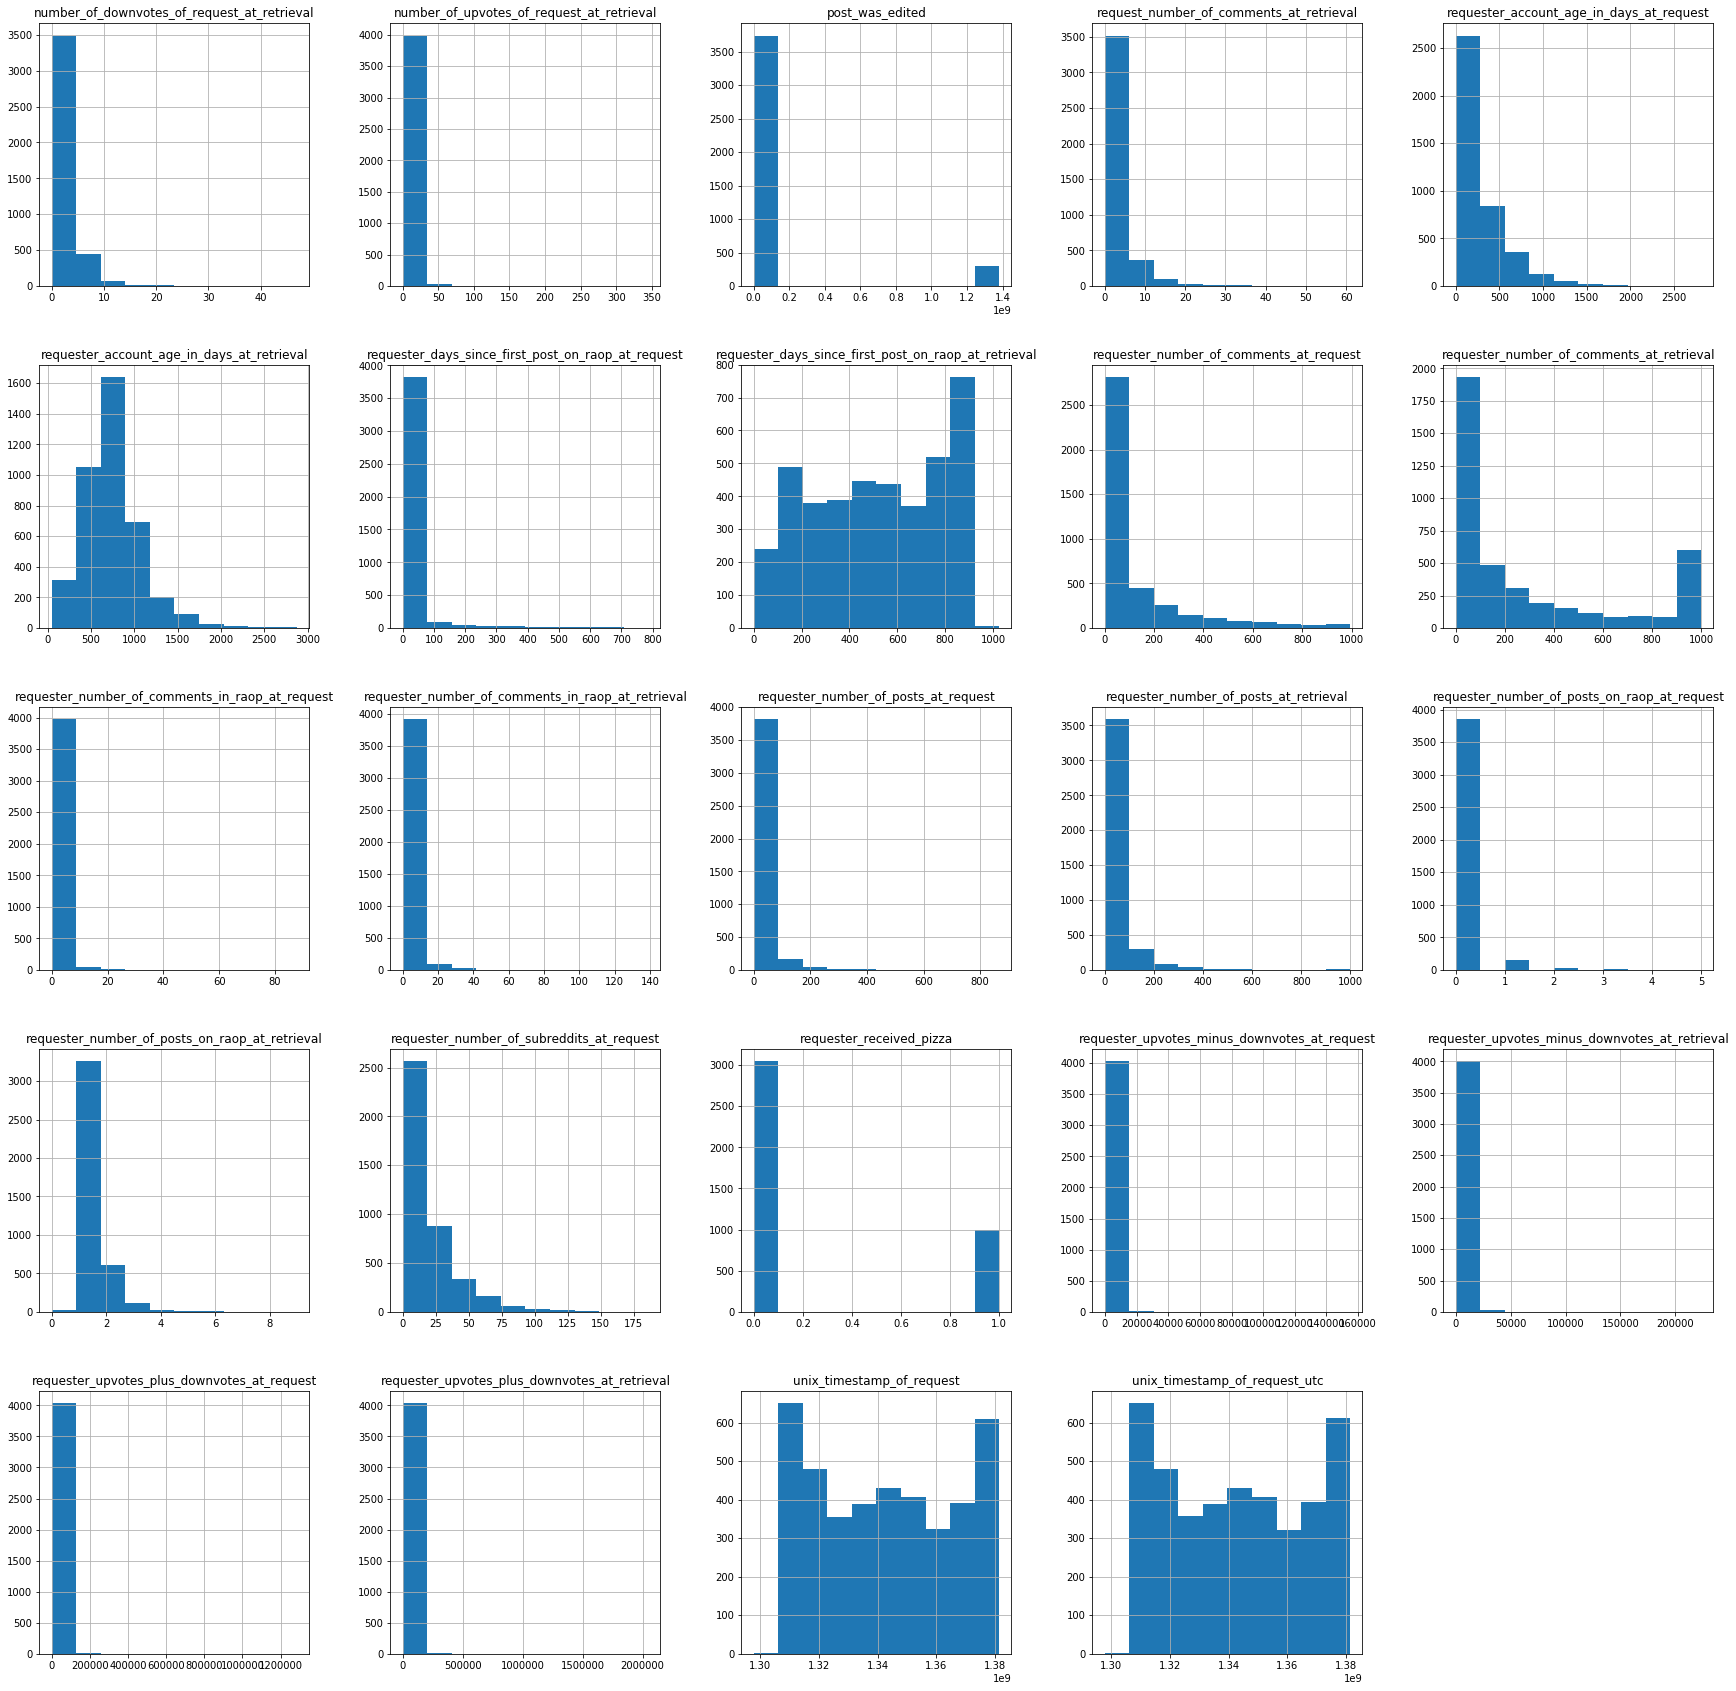

In [4]:
train_df.hist(figsize=(30,30))
plt.show()

Let us view the correlation information for the features in our training dataset:

In [5]:
corr_matrix = train_df.corr()
corr_matrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.460637
request_number_of_comments_at_retrieval                 0.289153
requester_number_of_comments_in_raop_at_retrieval       0.274253
requester_number_of_posts_on_raop_at_request            0.137208
requester_number_of_comments_in_raop_at_request         0.131296
requester_days_since_first_post_on_raop_at_retrieval    0.129283
requester_account_age_in_days_at_retrieval              0.120919
requester_number_of_comments_at_retrieval               0.105217
number_of_upvotes_of_request_at_retrieval               0.102138
requester_days_since_first_post_on_raop_at_request      0.098225
requester_upvotes_minus_downvotes_at_retrieval          0.077728
post_was_edited                                         0.049480
requester_number_of_posts_at_retrieval                  0.048353
requester_upvotes_plus_downvotes_at_retrieval           0.045994
requester_account_age_in_

## Feature Selection and Extraction

Let us extract features from the non-textual data that could be useful to build our model.

In [6]:
def create_features(df):
    
    # Whether or not the user was subscribed to exactly 0 subreddits
    df['zero_subreddits'] = df['requester_number_of_subreddits_at_request'] == 0

    # Total number of comments + number of random acts of pizza comments
    df['total_comments'] = (df['requester_number_of_comments_in_raop_at_request'] +
                                 df['requester_number_of_comments_at_request'])

    # The ratio of the user's total comments to their number of random acts of pizza comments
    df['comment_ratio'] = (df['total_comments'] /
                                df['requester_number_of_comments_in_raop_at_request'])
    
    df.loc[df['comment_ratio'] == np.inf, 'comment_ratio'] = \
        df.loc[df['comment_ratio'] != np.inf, 'comment_ratio'].mean(skipna = True)
    
    df.loc[pd.isnull(df['comment_ratio']), 'comment_ratio'] = \
        df.loc[pd.notnull(df['comment_ratio']), 'comment_ratio'].mean(skipna = True)

    # The number of upvotes they've received
    df['upvotes'] = (df['requester_upvotes_minus_downvotes_at_request'] +
                       df['requester_upvotes_plus_downvotes_at_request']) / 2

    # The number of downvotes they've received
    df['downvotes'] = (df['requester_upvotes_plus_downvotes_at_request'] -
                             df['upvotes'])
    
    # The ratio of upvotes they've received
    df['upvote_ratio'] = (df['upvotes'] /
                               (df['upvotes'] + df['downvotes']))
    
    df.loc[df['upvote_ratio'] == np.inf, 'upvote_ratio'] = \
        df.loc[df['upvote_ratio'] != np.inf, 'upvote_ratio'].mean(skipna = True)

    df.loc[pd.isnull(df['upvote_ratio']), 'upvote_ratio'] = \
        df.loc[pd.notnull(df['upvote_ratio']), 'upvote_ratio'].mean(skipna = True)

    # Get the date in order to make future variables
    df['date'] = pd.to_datetime(df['unix_timestamp_of_request_utc'], unit = 's')

    # Hour of the post
    df['hour'] = pd.DatetimeIndex(df['date']).hour

    # Day of the post
    df['day'] = pd.DatetimeIndex(df['date']).day

    # The post's day of the week
    df['weekday'] = pd.DatetimeIndex(df['date']).weekday

    # Whether the post was made in the first half of the month
    df['first_half_of_month'] = df['day'] <= 15
    df['first_half_of_month'] = df['first_half_of_month'].astype(int)

    # Whether the post was made on a weekend
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    df['weekend'] = df['weekend'].astype(int)

    # Whether the post was made in the morning
    df['morning'] = (df['hour'] >= 6) & (df['hour'] < 12)
    df['morning'] = df['morning'].astype(int)

    # Whether the post was made in the afternoon
    df['afternoon'] = (df['hour'] >= 12) & (df['hour'] < 16)
    df['afternoon'] = df['afternoon'].astype(int)

    # Whether the post was made in the evening
    df['evening'] = (df['hour'] >= 16) & (df['hour'] < 20)
    df['evening'] = df['evening'].astype(int)

    # Whether the post was made at night
    df['night'] = (df['hour'] >= 20) & (df['hour'] < 23)
    df['night'] = df['night'].astype(int)

    # Whether the post was made late at night
    df['latenight'] = (df['hour'] >= 23) & (df['hour'] < 6)
    df['latenight'] = df['latenight'].astype(int)

    # Whether there was a difference between the utc and unix timestamp
    df['utcdiff'] = (df['unix_timestamp_of_request_utc'] -
                              df['unix_timestamp_of_request'])

    # Month of the post
    df['month'] = pd.DatetimeIndex(df['date']).month

    # Week of the post
    df['week'] = pd.DatetimeIndex(df['date']).week
    
    # Get the US federal holidays and categorize the request dates as holiday or not.
    cal = USFederalHolidayCalendar()
    holiday_list = cal.holidays(start=df['date'].min(),
                            end=df['date'].max())
    holiday_list = [time.date() for time in holiday_list]

    df['justdate'] = [time.date() for time in df['date']]
    df['holiday'] = df['justdate'].isin(holiday_list)
    df['holiday'] = df['holiday'].astype(int)

    return(df)

train_df = create_features(train_df)
test_df = create_features(test_df)

Then we extract features from the textual data, mainly the title and the request text fields. We use the NTLK package to compute sentiment scores on the request text and the textstat package to compute further extract attributes from the text of the title and the request text.


In [7]:
### Adding text features
def create_text_features(df):
    # Training data with engineered features
    df_new = df
    
    # Sentiment analysis for the posts. We are looking at only posts that have a high postive or negative sentiment
    # and appending them as features columns 'positive_sentiment' and 'negative_sentiment' respectively.
    sid = SentimentIntensityAnalyzer()
    df_new['positive_sentiment']=df.request_text_edit_aware.apply(lambda x: sid.polarity_scores(x)['compound']>=0.5)
    df_new['negative_sentiment']=df.request_text_edit_aware.apply(lambda x: sid.polarity_scores(x)['compound']<=-0.5)
    
    # Length of the post's title
    df_new['title_len'] = df.request_title.str.len()

    # Length of the post's text
    df_new['request_len'] = df.request_text_edit_aware.str.len()

    # Number of words in title
    df_new['title_words'] = df['request_title'].apply(lambda x: len(x.split(' ')))

    # Number of words in body
    df_new['body_words'] = df['request_text_edit_aware'].apply(lambda x: len(x.split(' ')))
    
    # Number of sentences in body
    sen_count = re.compile(r'([a-zA-Z][^\.!?]*[\.!?])', re.M)
    df_new['body_sentences'] = df['request_text_edit_aware'].apply(lambda x: len(sen_count.findall(x)))

    # Post includes an image
    image_count = re.compile(r'(imgur\.com|\.jpg)', re.IGNORECASE)
    images = df['request_text_edit_aware'].apply(lambda x: len(image_count.findall(x)))
    df_new['has_image'] = np.where(images > 0,1,0)

    # Post includes a 'tl;dr'
    tldr_count = re.compile(r'(tl;dr|tldr|tl,dr|tl:dr)', re.IGNORECASE)
    tldrs = df['request_text_edit_aware'].apply(lambda x: len(tldr_count.findall(x)))
    df_new['has_tldr'] = np.where(tldrs > 0,1,0)

    # More than zero all-caps words in title (min char = 3)
    df_new['title_caps'] = df['request_title'].apply( \
        lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 3) > 0, 1,0))

    # More than zero all-caps words in body (min char = 2)
    df_new['body_caps'] = df['request_text_edit_aware'].apply( \
        lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 2) > 0, 1,0))

    # Exclamation marks in title
    excl_marks = re.compile(r'(!)', re.M)
    df_new['excl_marks_title'] = df['request_title'].apply(lambda x: len(excl_marks.findall(x)))
    # print train_df_f['excl_marks']

    # Exclamation marks in body
    df_new['excl_marks_body'] = df['request_text_edit_aware'].apply(lambda x: len(excl_marks.findall(x)))

    # Dollar signs in title
    dollar_signs = re.compile(r'(\$|dollar)', re.IGNORECASE)
    df_new['dollars_title'] = df['request_title'].apply(lambda x: len(dollar_signs.findall(x)))

    # Dollar signs in body
    df_new['dollars_body'] = df['request_text_edit_aware'].apply(lambda x: len(dollar_signs.findall(x)))
    
    # Categories
    desire = re.compile(r'(christmas|hungry|xmas|ramen|friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|starving)', re.IGNORECASE)
    family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
    job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
    money = re.compile(r'(foodstamps|money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|credit|budget|day|now| \
        time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
    student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
    
    df_new['desire_category'] = df['request_text_edit_aware'].apply(lambda x: len(desire.findall(x)))
    df_new['family_category'] = df['request_text_edit_aware'].apply(lambda x: len(family.findall(x)))
    df_new['job_category'] = df['request_text_edit_aware'].apply(lambda x: len(job.findall(x)))
    df_new['money_category'] = df['request_text_edit_aware'].apply(lambda x: len(money.findall(x)))
    df_new['student_category'] = df['request_text_edit_aware'].apply(lambda x: len(student.findall(x)))
    
    # Gratitude
    gratitude = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)',re.IGNORECASE)
    df_new['gratitude'] = df['request_text_edit_aware'].apply(lambda x: np.where(len(gratitude.findall(x)) > 0, 1, 0))
    
    # Reciprocity
    reciprocity = re.compile(r'(pay it forward|pay forward|paid it forward|pay the act forward|pay the favor back|paying it forward|pay this forward|pay pizza forward|pay back|pay it back|pay you back|return the favor|return the favour|pay a pizza forward|repay|reciprocate)',re.IGNORECASE)    
    df_new['reciprocity'] = df['request_text_edit_aware'].apply(lambda x: np.where(len(reciprocity.findall(x))> 0, 1, 0))
    
    df_new['locality_in_title']=df.apply(lambda x: 1 if expresses_locality(x['request_title']) else 0, axis=1).astype(int)
    df_new['locality_in_text']=df.apply(lambda x: 1 if expresses_locality(x['request_text_edit_aware']) else 0, axis=1).astype(int)
    df_new['flesch_reading_ease_text']=df.apply(lambda x: textstat.flesch_reading_ease(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['flesch_reading_ease_title']=df.apply(lambda x: textstat.flesch_reading_ease(x['request_title']), axis=1).astype(float)
    df_new['smog_index_text']=df.apply(lambda x: textstat.smog_index(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['smog_index_title']=df.apply(lambda x: textstat.smog_index(x['request_title']), axis=1).astype(float)
    df_new['flesch_kincaid_grade_text']=df.apply(lambda x: textstat.flesch_kincaid_grade(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['flesch_kincaid_grade_title']=df.apply(lambda x: textstat.flesch_kincaid_grade(x['request_title']), axis=1).astype(float)
    df_new['coleman_liau_index_text']=df.apply(lambda x: textstat.coleman_liau_index(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['coleman_liau_index_title']=df.apply(lambda x: textstat.coleman_liau_index(x['request_title']), axis=1).astype(float)
    df_new['automated_readability_index_text']=df.apply(lambda x: textstat.automated_readability_index(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['automated_readability_index_title']=df.apply(lambda x: textstat.automated_readability_index(x['request_title']), axis=1).astype(float)
    df_new['dale_chall_readability_score_text']=df.apply(lambda x: textstat.dale_chall_readability_score(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['dale_chall_readability_score_title']=df.apply(lambda x: textstat.dale_chall_readability_score(x['request_title']), axis=1).astype(float)
    df_new['difficult_words_text']=df.apply(lambda x: textstat.difficult_words(x['request_text_edit_aware']), axis=1).astype(int)
    df_new['difficult_words_title']=df.apply(lambda x: textstat.difficult_words(x['request_title']), axis=1).astype(int)
    df_new['linsear_write_formula_text']=df.apply(lambda x: textstat.linsear_write_formula(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['linsear_write_formula_title']=df.apply(lambda x: textstat.linsear_write_formula(x['request_title']), axis=1).astype(float)
    df_new['gunning_fog_text']=df.apply(lambda x: textstat.gunning_fog(x['request_text_edit_aware']), axis=1).astype(float)
    df_new['gunning_fog_title']=df.apply(lambda x: textstat.gunning_fog(x['request_title']), axis=1).astype(float)
    df_new['text_standard_text']=df.apply(lambda x: textstat.text_standard(x['request_text_edit_aware'],float_output=True), axis=1).astype(float)
    df_new['text_standard_title']=df.apply(lambda x: textstat.text_standard(x['request_title'],float_output=True), axis=1).astype(float)
    df_new['sentence_count_text']=df.apply(lambda x: textstat.sentence_count(x['request_text_edit_aware']), axis=1).astype(int)
    df_new['sentence_count_title']=df.apply(lambda x: textstat.sentence_count(x['request_title']), axis=1).astype(int)
    
    return(df_new)

train_df = create_text_features(train_df)
test_df = create_text_features(test_df)

We will convert the categorical variables ['hour', 'week', 'day', 'weekday', 'month', 'utcdiff'] into binary variables, and drop all unused features in our dataset.

In [8]:
test_requests_id=test_df['request_id']
train_data_categorical = train_df[['hour', 'week', 'day', 'weekday', 'month', 'utcdiff']]
test_data_categorical = test_df[['hour', 'week', 'day', 'weekday', 'month', 'utcdiff']]

train_data = train_df.drop(['request_text', 
                            'giver_username_if_known', 'post_was_edited',
                            'request_id', 
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username', 'requester_user_flair',
                            'number_of_downvotes_of_request_at_retrieval',
                            'number_of_upvotes_of_request_at_retrieval',
                            'request_number_of_comments_at_retrieval',
                            'requester_account_age_in_days_at_retrieval',
                            'requester_days_since_first_post_on_raop_at_retrieval',
                            'requester_number_of_comments_at_retrieval',
                            'requester_number_of_comments_in_raop_at_retrieval',
                            'requester_number_of_posts_at_retrieval',
                            'requester_number_of_posts_on_raop_at_retrieval',
                            'requester_upvotes_minus_downvotes_at_retrieval',
                            'requester_upvotes_plus_downvotes_at_retrieval',
                            'date', 'hour', 'week', 'day', 'weekday', 'month', 'utcdiff', 'justdate'
                            ],
                           axis = 1)

test_data = test_df.drop(['giver_username_if_known', 'request_id',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username',
                            'date', 'hour', 'week', 'day', 'weekday', 'month', 'utcdiff', 'justdate'
                            ],
                           axis = 1)

train_data_dummy = pd.DataFrame(index = train_data.index)
test_data_dummy = pd.DataFrame(index = test_data.index)

for column in train_data_categorical.columns:
    train_data_dummy = pd.concat([train_data_dummy,
                                  pd.get_dummies(train_data_categorical[column],
                                                prefix = column)], axis = 1)    
    test_data_dummy = pd.concat([test_data_dummy,
                                 pd.get_dummies(test_data_categorical[column],
                                                prefix = column)], axis = 1)

train_data = pd.concat([train_data, train_data_dummy], axis = 1)
test_data = pd.concat([test_data, test_data_dummy], axis = 1)

Let us do a 70:30 split to create the training and validation data sets, and extract the 'requester_received_pizza' column to create the train_labels and dev_labels dataframes. We will oversample the training dataset post split taking care not to affect the validation set.

In [9]:
# 70:30 split to create the training and validation data set.
train_data1, dev_data1 = train_test_split(train_data, test_size=0.30)

train_df_fail = train_data1[train_data1['requester_received_pizza'] == 0]
train_df_success = train_data1[train_data1['requester_received_pizza'] == 1]

# Oversample the success records to balance the skewed classes.
train_data1 = pd.concat([train_df_fail, train_df_success.sample(len(train_df_fail.index),replace=True)], axis = 0)
print (train_data1.groupby(['requester_received_pizza']).size())

train_labels = np.ravel(train_data1[['requester_received_pizza']])
train_data1 = train_data1.drop(['requester_received_pizza'],axis = 1)

# Create the text dataset for the text classification step.
train_data_text1=train_data1['request_text_edit_aware']
train_data1 = train_data1.drop(['request_text_edit_aware'],axis = 1)

# Repeat the steps for the validation data set.
dev_labels = np.ravel(dev_data1[['requester_received_pizza']])
dev_data1 = dev_data1.drop(['requester_received_pizza'],axis = 1)
dev_data_text1=dev_data1['request_text_edit_aware']
dev_data1 = dev_data1.drop(['request_text_edit_aware'],axis = 1)

# Repeat the steps for the holdout dataset.
test_data_text1=test_data['request_text_edit_aware']
test_data1 = test_data.drop(['request_text_edit_aware'],axis = 1)

print ("\nTraining Data shape : %s" % str(train_data1.shape))
print ("Validation Data shape : %s" % str(dev_data1.shape))
print ("Test Data shape : %s" % str(test_data1.shape))

requester_received_pizza
False    2132
True     2132
dtype: int64

Training Data shape : (4264, 198)
Validation Data shape : (1212, 198)
Test Data shape : (1631, 198)


## Text Classification

Our dataset is now transformed from 17 features to 198 features. For building a model on the textual data, we will use a TfidfVectorizer and a Logistic Regression classifier.

In [10]:
# Use basic pre-processing techniques
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def better_preprocessor(s):
    if len(s)>1: 
      for char in string.punctuation:
         s = s.replace(char, ' ').lower()
    elif (s.isdigit()):
        s = ' '
    else: s=' '        
    return s

def stemming_tokenizer(str_input):
    words = str_input.split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

             precision    recall  f1-score   support

      False       0.82      0.61      0.70       914
       True       0.33      0.58      0.42       298

avg / total       0.70      0.61      0.63      1212



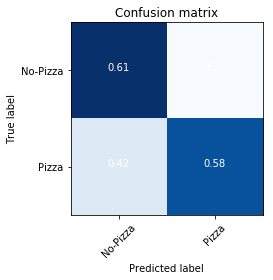

Metrics.roc_auc_score : 0.598292


In [11]:
tfid = TfidfVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                     ,tokenizer=stemming_tokenizer,
                       ngram_range=(1,1)    
                     )
tfid.fit(train_data_text1)
text_clf = LogisticRegression(C=0.01,penalty='l2',random_state=42)
text_clf.fit(tfid.transform(train_data_text1),train_labels)
y_pred=text_clf.predict(tfid.transform(dev_data_text1))
evaluate(class_names,dev_labels,y_pred,True)

## Non-Text Classification

Let us fit a Logistic Regression model on this dataset, and evaluate the model against the validation dataset.

             precision    recall  f1-score   support

      False       0.83      0.68      0.75       914
       True       0.37      0.58      0.45       298

avg / total       0.72      0.66      0.68      1212



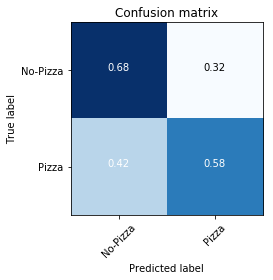

Metrics.roc_auc_score : 0.631041


In [12]:
logistic = LogisticRegression(C=0.1,penalty='l2',random_state=42)
logistic.fit(train_data1, train_labels)
evaluate(class_names,dev_labels,logistic.predict(dev_data1))

We are getting an roc_auc_score of 63%. A GridSearch to find the best value of C has already been incorporated. 

Let us view the feature importances from our Logistic Regression Model.

In [13]:
feature_importances={name:importance for name, importance in sorted(zip(train_data1.columns, logistic.coef_[0]), key=lambda tup: tup[1], reverse=True)}
feature_importances_df=pd.DataFrame.from_dict(feature_importances, orient='index')
feature_importances_df.columns = ['Importance']
pd.options.display.max_rows = 4000
feature_importances_df.round(4).sort_values(by=['Importance'],ascending=False)

,Importance
week_26,0.7962
has_image,0.6066
requester_number_of_posts_on_raop_at_request,0.5196
week_52,0.4049
week_23,0.3623
hour_18,0.3210
day_11,0.3200
month_7,0.3124
day_22,0.3124
day_17,0.3119


We can see that certain features have a strong positive or negative influence in our model. The has_image, requester_number_of_posts_on_raop_at_request, certain days like week 26 which is mostly likely the July 4th weekend in the US and week 52 which is the week between Christmas and the New Year, reciprocity etc. have a strong positive influence and zero_subreddits, negative_sentiment, a morning post, day_28 post etc. have a strong negative influence.

## Building an Ensemble Classifier

Now we have 2 models - one on the Text data and one on the Non-Text data. Let us build an ensemble model that would be a weighted combination of the predictions from both the models.

We will use the scikit minimize function to find the weights that minimize the log_loss.

In [14]:
predictions=[]
predictions.append(text_clf.predict_proba(tfid.transform(dev_data_text1)))
predictions.append(logistic.predict_proba(dev_data1))
dev_probabilities=[int(k) for k in dev_labels]

In [15]:
def log_loss_func(weights):
    final_prediction = 0
    ''' scipy minimize will pass the weights as a numpy array '''
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction
    return log_loss(dev_probabilities, final_prediction)

In [16]:
starting_values = [0,1]

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})

#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 0.6295657884918547
Best Weights: [0.11784777 0.88215223]


We have found the weights that we need to use for our ensemble model. Let us get the final predictions and evaluate the results.

             precision    recall  f1-score   support

      False       0.83      0.69      0.75       914
       True       0.38      0.58      0.46       298

avg / total       0.72      0.66      0.68      1212



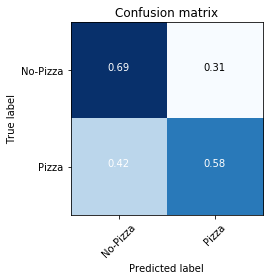

Metrics.roc_auc_score : 0.633266


In [17]:
weights=res['x']
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(dev_data1))]
y_pred=[True if k > 0.5 else False for k in y_pred]
evaluate(class_names,dev_labels,y_pred,True)

We see that the roc_auc_score for the ensemble model is better than each of the individual models.

## Kaggle Submission

Now that we have an ensemble model, let us run predictions on the test data and generate a CSV file to upload submissions to Kaggle.

In [18]:
predictions=[]
predictions.append(text_clf.predict_proba(tfid.transform(test_data_text1)))
predictions.append(logistic.predict_proba(test_data1))
weights=res['x']
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(test_data1))]
y_pred=[True if k > 0.5 else False for k in y_pred]

In [19]:
x = np.array(y_pred).reshape(-1,1)
final_df = pd.DataFrame.from_records(x,columns=['requester_received_pizza'])
final_df=final_df.join(test_requests_id)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.requester_received_pizza=final_df.requester_received_pizza.astype(int)

In [20]:
print (final_df.groupby(['requester_received_pizza']).size())
final_df.to_csv('final_submission.csv',header=True,index=False)

requester_received_pizza
0    1057
1     574
dtype: int64


## Conclusion